In [134]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import optuna
import matplotlib.pyplot as plt
import graphviz
import pickle
import numpy as np
import pandas as pd
import lightgbm as lgbm
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from optuna import Trial, visualization
from optuna.samplers import TPESampler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.model_selection import KFold as KFold
from sklearn.metrics import f1_score, mean_squared_error, accuracy_score
from sklearn.ensemble import VotingClassifier

## 데이터 불러오기

In [15]:
disease_origin = pd.read_csv('/Users/choeunsol/Python/dl_study/open/train.csv')

In [16]:
disease_origin.columns

Index(['ID', 'Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
       'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

<AxesSubplot:>

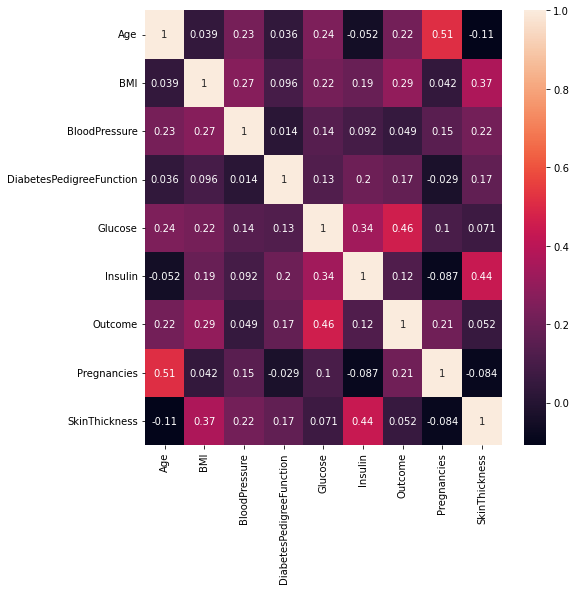

In [17]:
disease_for_corr = disease_origin[disease_origin.columns.difference(['ID'])]
corr_d = disease_for_corr.corr()

plt.figure(figsize = (8,8))
sns.heatmap(corr_d, annot = True)

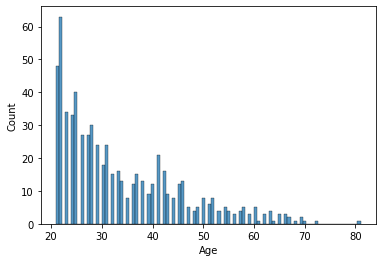

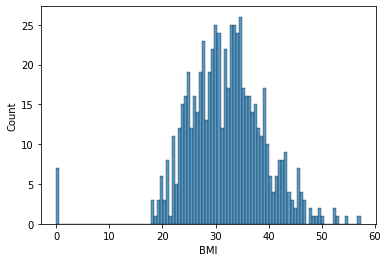

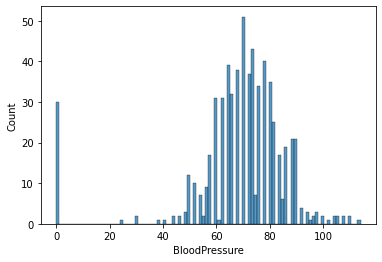

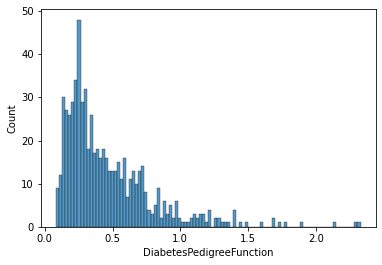

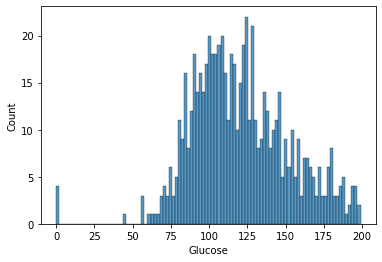

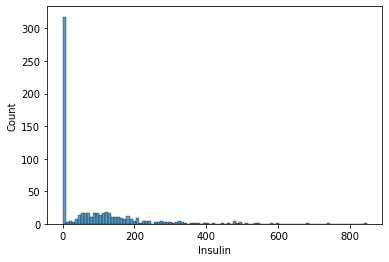

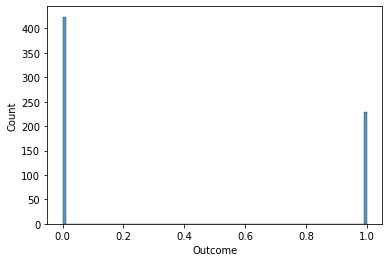

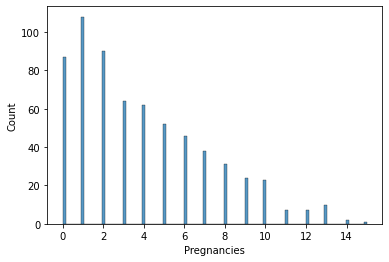

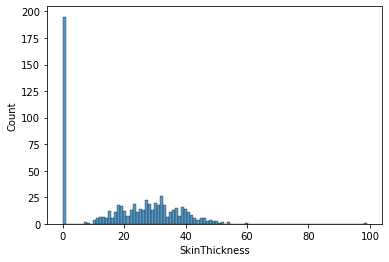

In [18]:
col = disease_for_corr.columns
for i in col:
    sns.histplot(disease_for_corr, x=i, stat = 'count', bins = 100)
    plt.show()

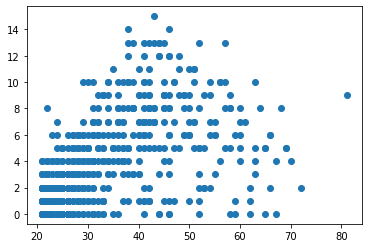

In [19]:
plt.scatter(disease_for_corr['Age'], disease_for_corr['Pregnancies'])

## EDA

1. Skin Thickness : 결측치 200개 이상, column 재외

2. 인슐린 : 0이 결측치가 아닌지 애매 > 인슐린 0일 때 scatter plot 그려보기

3. BMI 0 > 평균 대체 : 결측치 수가 많지 않고, 데이터가 정규분포에 근사

4. 혈압 0 > Regression 혹은 평균 대체 활용 : 결측치 비율 약 5%

5. 데이터 수가 많지 않아 Validation으로 Pure Model과 Improved Model 비교 가능

모델링 하기 전 무조건 해야 할 것 : 1, 3, 4(평균 대체 먼저)

모델링 후 확인 : 2, 5

### 인슐린 Decision

In [20]:
disease_for_corr.shape

(652, 9)

In [21]:
disease_for_corr.groupby('Insulin').mean().loc[:, 'Outcome'][0]

0.3805031446540881

In [22]:
insulin_decision = disease_for_corr.loc[:, ['Insulin', 'Outcome']]
insulin_decision['one_hot_insulin'] = np.where((insulin_decision['Insulin'] == 0), 0, 1)
insulin_decision.groupby('one_hot_insulin').value_counts()[0]

Insulin  Outcome
0        0          197
         1          121
dtype: int64

In [23]:
insulin_decision.groupby('one_hot_insulin').mean().iloc[:, 1]

one_hot_insulin
0    0.380503
1    0.320359
Name: Outcome, dtype: float64

인슐린 0인 사람과 데이터가 1인 사람 사이에 유의미한 차이가 있다(향후 t-test 예정).

따라서 insulin data를 집어넣은 것으로 한다.

### 결측치 대체

### BMI

In [26]:
bmi_replace = disease_for_corr.loc[:,'BMI'].replace(0, disease_for_corr['BMI'].mean())
bp_replace = disease_for_corr.loc[:, 'BloodPressure'].replace(0, disease_for_corr['BloodPressure'].mean())

In [112]:
disease_for_analysis = disease_for_corr.copy()
disease_for_analysis['BMI'] = bmi_replace
disease_for_analysis['BloodPressure'] = bp_replace

In [31]:
disease_for_analysis = disease_for_analysis[lambda x : x.columns.difference(['SkinThickness'])]
disease_for_analysis

,Age,BMI,BloodPressure,DiabetesPedigreeFunction,Glucose,Insulin,Outcome,Pregnancies
0,33,24.0,60.0,0.966,103,192,0,4
1,36,27.0,68.0,0.245,133,0,0,10
2,38,39.4,78.0,0.236,112,0,0,4
3,26,45.3,88.0,0.507,119,170,0,1
4,21,38.1,66.0,0.289,114,200,0,1
...,...,...,...,...,...,...,...,...
647,21,29.2,64.0,0.192,91,0,0,1
648,41,31.2,68.0,0.258,122,0,0,10
649,39,38.3,74.0,0.457,84,0,0,8
650,25,30.1,72.0,0.547,81,76,0,2


## 분석

### 정규화 for logistic

In [33]:
disease_for_analysis

,Age,BMI,BloodPressure,DiabetesPedigreeFunction,Glucose,Insulin,Outcome,Pregnancies
0,33,24.0,60.0,0.966,103,192,0,4
1,36,27.0,68.0,0.245,133,0,0,10
2,38,39.4,78.0,0.236,112,0,0,4
3,26,45.3,88.0,0.507,119,170,0,1
4,21,38.1,66.0,0.289,114,200,0,1
...,...,...,...,...,...,...,...,...
647,21,29.2,64.0,0.192,91,0,0,1
648,41,31.2,68.0,0.258,122,0,0,10
649,39,38.3,74.0,0.457,84,0,0,8
650,25,30.1,72.0,0.547,81,76,0,2


In [37]:
analysis_for_logistic = disease_for_analysis.copy()
analysis_for_tree_based = disease_for_analysis.copy()

predictor_for_logistic = disease_for_analysis[lambda x : x.columns.difference(['Outcome'])]

,Age,BMI,BloodPressure,DiabetesPedigreeFunction,Glucose,Insulin,Pregnancies
0,33,24.0,60.0,0.966,103,192,4
1,36,27.0,68.0,0.245,133,0,10
2,38,39.4,78.0,0.236,112,0,4
3,26,45.3,88.0,0.507,119,170,1
4,21,38.1,66.0,0.289,114,200,1
...,...,...,...,...,...,...,...
647,21,29.2,64.0,0.192,91,0,1
648,41,31.2,68.0,0.258,122,0,10
649,39,38.3,74.0,0.457,84,0,8
650,25,30.1,72.0,0.547,81,76,2


In [60]:
## Sclaler : StandardScaler()

logistic_scaler = StandardScaler()
logistic_scaler.fit(predictor_for_logistic)

predictor_for_logistic[:] = logistic_scaler.transform(predictor_for_logistic)

/var/folders/d7/8zsbg3r51rs_vl832mx18q_00000gn/T/ipykernel_59721/449603118.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictor_for_logistic[:] = logistic_scaler.transform(predictor_for_logistic)


### Logistic Regression


In [64]:
logistic_X = predictor_for_logistic
logistic_y = disease_for_analysis['Outcome']

In [67]:
logistic_disease = LogisticRegression()

logistic_X_train, logistic_X_val, logistic_y_train, logistic_y_val = train_test_split(logistic_X, logistic_y, test_size = 0.3, random_state = 0)
# Validation Data 나누기

logistic_disease.fit(logistic_X_train, logistic_y_train)
logistic_disease.score(logistic_X_val, logistic_y_val)

0.7397959183673469

Logistic Regression : Validation Score 0.74

### LightBoost + Optuna tuning


In [69]:
import os
os.chdir('/Users/choeunsol/Python/function')

from tuning_generalization import light_objective

In [93]:
# X와 y : Tree Based에서 활용

tree_based_X_train = disease_for_analysis[lambda x : x.columns.difference(['Outcome'])]
tree_based_y_train = disease_for_analysis['Outcome']

# tuning function

def light_objective(trial : Trial, train_x, train_y, regressor_name = 'regressor'):

    params_lgbm = {
        'random_state' : 0,
        'n_estimators' : trial.suggest_int('n_estimators', 5, 50),
        'max_depth': trial.suggest_int('max_depth', 2, 20),
        'num_leaves': trial.suggest_categorical('max_leaves', [2**i for i in range(2, 5)]),
        'subsample': trial.suggest_uniform('subsample', 0.0, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.0, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 10.0)    
    }

    if regressor_name == 'regressor':
        kf = KFold(n_splits = 5, shuffle = True, random_state = 0)
        rmse_list = []
        for train_index, valid_index in kf.split(train_x):
            model_reg = lgbm.LGBMRegressor(**params_lgbm)
            train_for_val_x, train_for_val_y = train_x.iloc[train_index], train_y.iloc[train_index]
            valid_x, valid_y = train_x.iloc[valid_index], train_y.iloc[valid_index]
            model_reg.fit(train_for_val_x, train_for_val_y, eval_set = [(train_for_val_x, train_for_val_y), (valid_x, valid_y)], verbose = False)
            xgb_pred = model_reg.predict(valid_x)
            rmse = np.sqrt(mean_squared_error(valid_y, xgb_pred))
            rmse_list.append(rmse) 
        return np.mean(rmse_list)
    
    elif regressor_name == 'classifier':
        stf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 0)
        accuracy_list = []
        for train_index, valid_index in stf.split(train_x, train_y):
            model_clf = lgbm.LGBMClassifier(**params_lgbm)
            train_for_val_x, train_for_val_y = train_x.iloc[train_index], train_y.iloc[train_index]
            valid_x, valid_y = train_x.iloc[valid_index], train_y.iloc[valid_index]
            model_clf.fit(train_for_val_x, train_for_val_y, eval_set = [(train_for_val_x, train_for_val_y), (valid_x, valid_y)], verbose = False)
            xgb_pred = model_clf.predict(valid_x)
            accuracy = accuracy_score(valid_y, xgb_pred) # 다중 분류의 경우 'micro', 'macro', 'samples', 'weighted' 중 하나 선택
            accuracy_list.append(accuracy) 
        return np.mean(accuracy_list)

In [96]:
sampler = TPESampler(seed = 0)

tuned_lgbm = optuna.create_study(
    study_name = 'lightboost params',
    direction = 'maximize',
    sampler = sampler
)

obj_lgbm = lambda trial : light_objective(trial, tree_based_X_train, tree_based_y_train, regressor_name='classifier')
tuned_lgbm.optimize(obj_lgbm, n_trials = 500)

[I 2023-03-25 17:13:04,990] A new study created in memory with name: lightboost params
/var/folders/d7/8zsbg3r51rs_vl832mx18q_00000gn/T/ipykernel_59721/1422787828.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'subsample': trial.suggest_uniform('subsample', 0.0, 1.0),
/var/folders/d7/8zsbg3r51rs_vl832mx18q_00000gn/T/ipykernel_59721/1422787828.py:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.0, 1.0),
/var/folders/d7/8zsbg3r51rs_vl832mx18q_00000gn/T/ipykernel_59721/1422787828.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v

In [120]:
tuned_lgbm.best_value

0.7744216089254257

In [109]:
## lgbm 모델

os.chdir('/Users/choeunsol/Python/dl_study/open')
test = pd.read_csv('test.csv')

X_test = test[lambda x : x.columns.difference(['ID', 'Outcome', 'SkinThickness'])]

In [116]:
## 결측치 대체

bmi_replace_test = X_test.loc[:,'BMI'].replace(0, disease_for_corr['BMI'].mean())
bp_replace_test = X_test.loc[:, 'BloodPressure'].replace(0, disease_for_corr['BloodPressure'].mean())

X_test.loc[:, 'BMI'], X_test.loc[:, 'BloodPressure'] = bmi_replace_test, bp_replace_test

/var/folders/d7/8zsbg3r51rs_vl832mx18q_00000gn/T/ipykernel_59721/3264525257.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.loc[:, 'BMI'], X_test.loc[:, 'BloodPressure'] = bmi_replace_test, bp_replace_test


In [125]:
lgbm_classifier = lgbm.LGBMClassifier(**tuned_lgbm.best_params)
lgbm_classifier.fit(tree_based_X_train, tree_based_y_train)
lgbm_predict = lgbm_classifier.predict(X_test)

[LightGBM] [Warning] num_leaves is set=31, max_leaves=8 will be ignored. Current value: num_leaves=31


In [126]:
## 제출
submit = pd.read_csv('sample_submission.csv')
submit['Outcome'] = lgbm_predict
submit.to_csv('submission.csv', index = False)

### xgBoost + 결측치 대체

In [127]:
def xgb_objective(trial : Trial, train_x, train_y, regressor_name = 'regressor'):
    
    params_xgb = {
        'random_state' : 0,
        'early_stopping_rounds' : 50,
        'n_estimators' : trial.suggest_int('n_estimators', 50, 200),
        'max_depth': trial.suggest_int('max_depth', 5, 15),
        'max_leaves': trial.suggest_categorical('max_leaves', [2**i for i in range(4, 10)]),
        'min_child_weight' : trial.suggest_int('min_child_weight', 1, 300),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 10.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.0, 1.0),
        'subsample': trial.suggest_uniform('subsample', 0.0, 1.0),
        'learning_rate':trial.suggest_uniform('learning_rate', 0.01, 0.5)
    }

    if regressor_name == 'regressor':
        kf = KFold(n_splits = 5, shuffle = True, random_state = 0)
        rmse_list = []
        for train_index, valid_index in kf.split(train_x):
            model_reg = xgb.XGBRegressor(**params_xgb)
            train_for_val_x, train_for_val_y = train_x.iloc[train_index], train_y.iloc[train_index]
            valid_x, valid_y = train_x.iloc[valid_index], train_y.iloc[valid_index]
            model_reg.fit(train_for_val_x, train_for_val_y, eval_set = [(train_for_val_x, train_for_val_y), (valid_x, valid_y)], verbose = False)
            xgb_pred = model_reg.predict(valid_x)
            rmse = np.sqrt(mean_squared_error(valid_y, xgb_pred))
            rmse_list.append(rmse) 
        return np.mean(rmse_list)
    
    elif regressor_name == 'classifier':
        stf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 0)
        accuracy_score_list = []
        for train_index, valid_index in stf.split(train_x, train_y):
            model_clf = xgb.XGBClassifier(**params_xgb)
            train_for_val_x, train_for_val_y = train_x.iloc[train_index], train_y.iloc[train_index]
            valid_x, valid_y = train_x.iloc[valid_index], train_y.iloc[valid_index]
            model_clf.fit(train_for_val_x, train_for_val_y, eval_set = [(train_for_val_x, train_for_val_y), (valid_x, valid_y)], verbose = False)
            xgb_pred = model_clf.predict(valid_x)
            accuracy = accuracy_score(valid_y, xgb_pred) # 다중 분류의 경우 'micro', 'macro', 'samples', 'weighted' 중 하나 선택
            accuracy_score_list.append(accuracy) 
        return np.mean(accuracy)

In [128]:
sampler = TPESampler(seed = 0)

tuned_xgb = optuna.create_study(
    study_name = 'xgboost params',
    direction = 'maximize',
    sampler = sampler
)

obj_xgb = lambda trial : xgb_objective(trial, tree_based_X_train, tree_based_y_train, regressor_name='classifier')
tuned_xgb.optimize(obj_lgbm, n_trials = 100)

[I 2023-03-25 19:17:17,971] A new study created in memory with name: xgboost params
/var/folders/d7/8zsbg3r51rs_vl832mx18q_00000gn/T/ipykernel_59721/1422787828.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'subsample': trial.suggest_uniform('subsample', 0.0, 1.0),
/var/folders/d7/8zsbg3r51rs_vl832mx18q_00000gn/T/ipykernel_59721/1422787828.py:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.0, 1.0),
/var/folders/d7/8zsbg3r51rs_vl832mx18q_00000gn/T/ipykernel_59721/1422787828.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0

### Voting Process

In [132]:
lgbm_classifier = lgbm.LGBMClassifier(**tuned_lgbm.best_params)
xgb_classifier = xgb.XGBClassifier(**tuned_xgb.best_params)
logistic_regressor = LogisticRegression()

In [1]:
## Voting Classifier
classifiers = [lgbm_classifier, xgb_classifier, logistic_regressor]
hard_vote_clf = VotingClassifier(estimators=[('lgbm', lgbm_classifier), ('xgb', xgb_classifier), ('LR', logistic_regressor)], voting= 'soft')
hard_vote_clf.fit(logistic_X, logistic_y)

# 로지스틱으로 인해 인풋은 StandardScaler로 정규화한다.
X_test_for_vote = logistic_scaler.transform(X_test)
voting_output = hard_vote_clf.predict(X_test_for_vote)

NameError: name 'lgbm_classifier' is not defined

In [146]:
submit = pd.read_csv('sample_submission.csv')
submit['Outcome'] = voting_output
submit.to_csv('submission_softvote.csv', index = False)